# Nenadzirano učenje

Nenadzirano učenje je vrsta strojnog učenja gdje je cilj istražiti strukturu dostupnih podataka kako bi izvukli važne informacije (npr. otkriti nekakva interesantna svojstva). Pri tome je raspoloživi skup podataka neoznačen (znači nećemo imati vrijednosti odgovarajuće izlazne veličine) i ne postoji sustav nagrađivanja tijekom učenja kao kod podržanog učenja.

Dva česta problema u nenadziranom učenju su grupiranje podataka i smanjivanje dimenzionalnosti i rekonstrukcija. U ovoj laboratorijskoj vježbi ćemo se baviti drugim problemom, smanjivanjem dimenzionalnosti i rekonstrukcijom. Za ovo ćemo koristiti autoenkodere.

## Autoenkoderi

Autoenkoderi su vrsta neuronskih mreža koje se koriste za učenje efikasnih reprezentacija podataka, a imaju široku primjenu u područjima poput kompresije podataka, generiranja slika i detekcije anomalija.

Autoenkoderi se sastoje od dvije osnovne komponente - enkodera i dekodera. Enkoder prima ulazni primjer i preslikava ga u kompaktni vektor (vektor niže dimenzije od ulaznog primjera). Dekoder zatim koristi taj vektor kako bi rekonstruirao originalni ulaz.

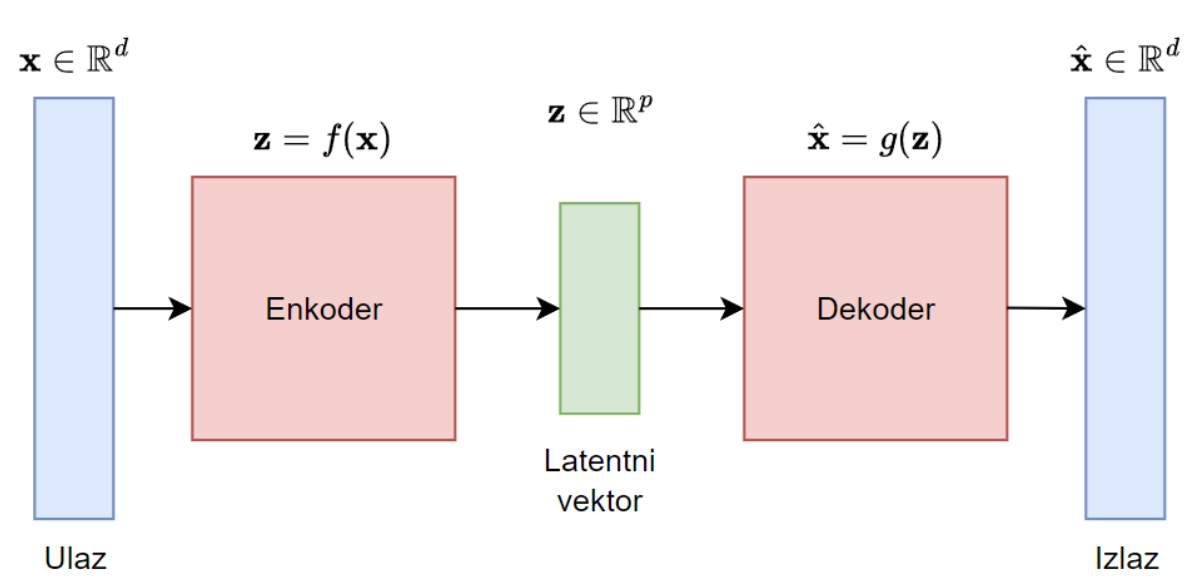

### Konvolucijski autoenkoder

Konvolucijski autoenkoderi koriste operacije konvolucije i [transponirane konvolucije](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html). U enkoderu je cilj smanjiti dimenzionalnost. Ovo se može postići na dva načina:
 - Korištenjem slojeva sažimanja za smanjenje dimenzionalnosti nakon konvolucijskih slojeva
 - Korištenjem *stridea* većeg od 1 u konvolucijskim slojevima, čime se također smanje dimenzije izlaznih matrica


 Postoje dva česta pristupa rekonstrukciji slike u dekoderu:
  - Korištenjem tzv. *upsampling* slojeva popraćenih standardnim konvolucijskim slojevima
  - Korištenjem transponirante konvolucije za povećanje dimenzionalnosti

  
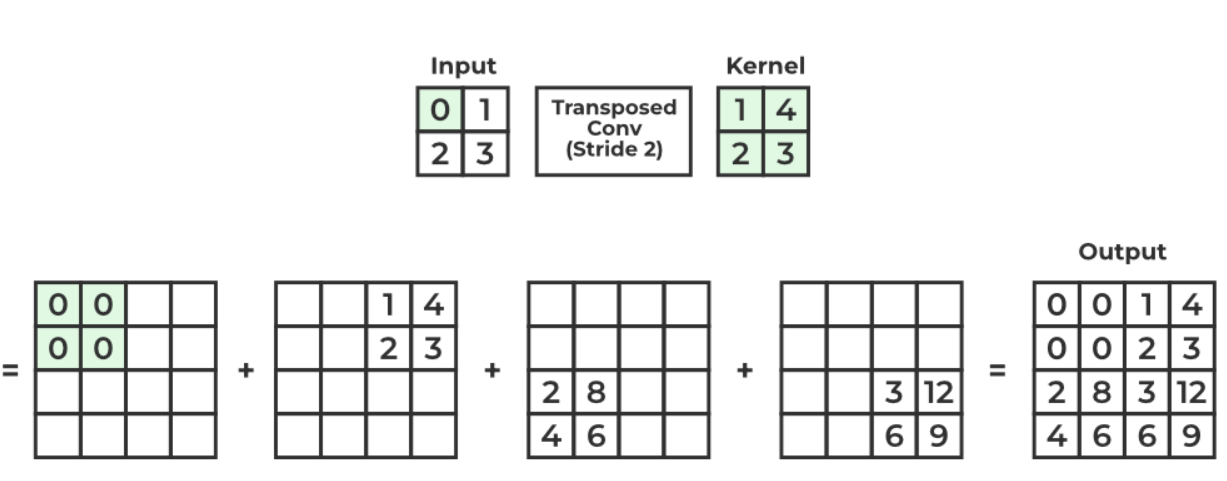

Dimenzije izlazne matrice iz konvolucije:
$$n_{out} = \frac{n_{in} + 2p - k}{s} + 1$$

Dimenzije izlazne matrice kod transponirane konvolucije:
$$n_{out} = s(n_{in} - 1) + k - 2p$$

Gdje su:
 - $n_{out}$ - dimenzija izlazne matrice
 - $n_{in}$ - dimenzija ulazne matrice
 - $k$ - dimenzija kernela
 - $s$ - *stride*
 - $p$ - *padding*

## Zadaci

1. Izradite konvolucijski autoenkoder sa sheme te ga istrenirajte na podatkovnom skupu [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html). Koristite BCELoss za funkciju gubitka. Brojevi na shemi prikazuju dimenzije izlazne matrice iz svakog pojedinog sloja, prvi broj predstavlja broj kanala. Istestirajte vaš autoenkoder i prikažite primjere parova ulaznih i izlanih slika.

2. Prilikom treniranja i testiranja dodajte normalan (Gaussov) šum na ulazne slike iz MNIST podatkovnog skupa. Vaš autoenkoder treba rekonstruirati slike bez dodanog šuma. Po potrebi prilagodite strukturu mreže. Isprobajte razne parametre šuma.

3. Izradite proizvoljan autoenkoder te ga istrenirajte na podatkovnom skupu [CelebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). Upute za dohvaćanje podatkovnog skupa dane su u nastavku. Također je potrebno izraditi vlastitu *dataset* klasu za dani podatkovni skup.

Dodatno:

Zacrnite nasumične pravokutnike na ulaznim slikama iz 3. zadatka te istrenirajte autoenkoder za uklanjanje pravokutnika. Isprobajte s različitim veličinama pravokutnika.

#### Shema mreže za prvi zadatak.

Plavom bojom su prikazani izlazi iz pojedinih slojeva enkodera, narančastom bojom su prikazani izlazi iz pojedinih slojeva dekodera. *Kernel size* i *stride* za sve slojeve trebaju biti 4 i 2. *Padding* prilagodite ovisno o željenoj veličini izlaza. Svi konvolucijski slojevi popraćeni su ReLU aktivacijskom funkcijom osim posljednjeg sloja u dekoderu, on je popraćen sigmoid aktivacijskom funkcijom kako bi se dobio izlaz između 0 i 1, odnosno u istom formatu kao što su ulazne slike.


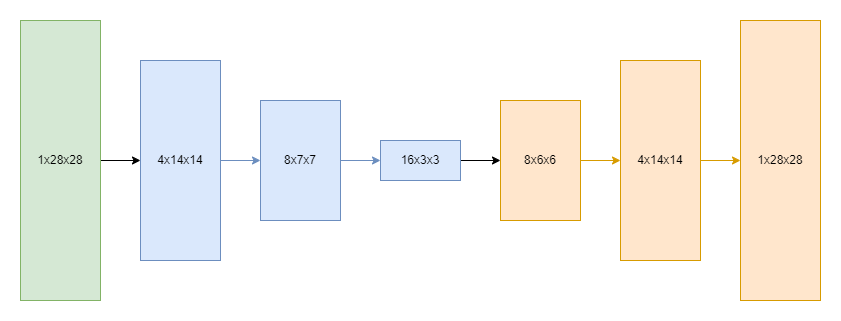

In [1]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(1568, 32 * 7 * 7)  # Adjusted the input size
        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.linear(x))
        x = x.view(-1, 32, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x


class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction

In [3]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Decoder(
    (linear): Linear(in_features=1568, out_features=1568, bias=True)
    (deconv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (deconv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2             [-1, 32, 7, 7]           4,640
           Flatten-3                 [-1, 1568]               0
           Encoder-4                 [-1, 1568]               0
            Linear-5                 [-1, 1568]       2,460,192
   ConvTranspose2d-6           [-1, 16, 14, 14]           4,624
   ConvTranspose2d-7            [-1, 1, 28, 28]             145
           Decoder-8            [-1, 1, 28, 28]               0
Total params: 2,469,761
Trainable params: 2,469,761
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 9.42
Estimated Total Size (MB): 9.53
----------------------------------------------------------------


In [5]:
def visualize(model, dataloader, noise_function, noise_param, n=4):
  fig, ax = plt.subplots(n, 2)

  for i in range(n):
    img = noise_function(next(iter(dataloader))[0][i], noise_param)
    img_ = img.numpy().transpose(1, 2, 0)
    ax[i, 0].imshow(img_)
    img = img.to(device)
    recon = model(img)
    recon_ = recon.detach().cpu().numpy().transpose(1, 2, 0)
    ax[i, 1].imshow(recon_)
  plt.show()

U nastavku slijede upute za rad s CelebA podatkovnog skupa. Pratite prva dva koraka prikazana [ovdje](https://www.kaggle.com/discussions/general/74235). Nakon toga `kaggle.json` datoteku stavite na svoj Google Drive. Preporučeno je staviti datoteku u root direktorij Google Drivea, ali možete ga staviti i na drugu lokaciju, ali onda trebate prilagoditi putanju u naredbi `! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/`.

Ukoliko primijetite da vam izlazne slike imaju rešetke (*grid*) ili su nalik na šahovnicu, pokušajte izraditi autoenkoder pomoću *pooling* i *upsampling* slojeva, bez korištenja transponiranih konvolucija. Više o ovom problemu, pročitajte [ovdje](https://distill.pub/2016/deconv-checkerboard/).

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                  Jobs and Salaries in Data Science                   76KB  2023-12-25 20:03:32           6665        121  1.0              
thedrcat/daigt-v2-train-dataset                             DAIGT V2 Train Dataset                              29MB  2023-11-16 01:38:36           4373        333  1.0              
bhavikjikadara/grocery-store-dataset                        Grocery Store Dataset                              391KB  2024-01-06 04:35:55           1251         27  1.0              
nelgiriyewithana/new-york

In [21]:
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:20<00:00, 56.8MB/s]
100% 1.33G/1.33G [00:20<00:00, 70.4MB/s]


In [22]:
%%capture
! unzip celeba-dataset.zip -d /content/celeba

In [23]:
dataset_path = '/content/celeba/img_align_celeba/img_align_celeba'
batch_size = 128

In [11]:
from torchvision.io import read_image
import os

class CustomImageDataset(data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.images[idx])
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        return image

In [12]:
def convert_image_dtype(image):
  return transforms.functional.convert_image_dtype(image)

In [13]:
img_transform = transforms.Compose([
    transforms.functional.convert_image_dtype,
    transforms.Resize((192, 192), antialias=True)
])

train_data = CustomImageDataset(dataset_path, img_transform)
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=2)

FileNotFoundError: [Errno 2] No such file or directory: '/content/celeba/img_align_celeba/img_align_celeba'

100%|██████████| 9912422/9912422 [00:00<00:00, 168716160.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 59409364.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44638237.40it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5488484.23it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10, Loss: 0.07253705710172653
Epoch 2/10, Loss: 0.07057178765535355
Epoch 3/10, Loss: 0.07113740593194962
Epoch 4/10, Loss: 0.06801304966211319
Epoch 5/10, Loss: 0.07117387652397156
Epoch 6/10, Loss: 0.06497897952795029
Epoch 7/10, Loss: 0.06302989274263382
Epoch 8/10, Loss: 0.06673212349414825
Epoch 9/10, Loss: 0.06329068541526794
Epoch 10/10, Loss: 0.0641731396317482


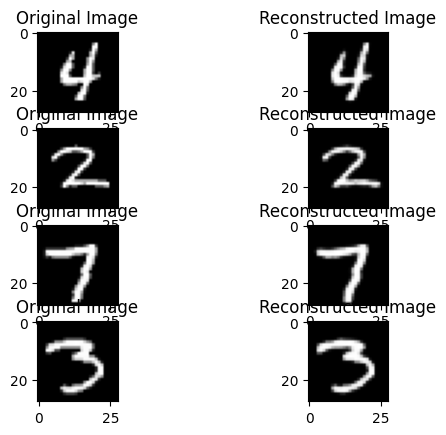

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms  # Import datasets module from torchvision
from torchsummary import summary
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Create an instance of the autoencoder and move it to the appropriate device
model = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Visualize examples of input and reconstructed images
def visualize(model, dataloader, n=4):
    model.eval()
    fig, ax = plt.subplots(n, 2)

    for i in range(n):
        img, _ = next(iter(dataloader))
        img = img.to(device)
        recon = model(img)

        img_ = img[0].detach().cpu().numpy().squeeze()
        recon_ = recon[0].detach().cpu().numpy().squeeze()

        ax[i, 0].imshow(img_, cmap='gray')
        ax[i, 0].set_title('Original Image')

        ax[i, 1].imshow(recon_, cmap='gray')
        ax[i, 1].set_title('Reconstructed Image')

    plt.show()

# Visualize examples
visualize(model, dataloader)

Epoch 1/10, Loss: 0.07259030640125275
Epoch 2/10, Loss: 0.07562362402677536
Epoch 3/10, Loss: 0.07010436058044434
Epoch 4/10, Loss: 0.07268361002206802
Epoch 5/10, Loss: 0.0722203254699707
Epoch 6/10, Loss: 0.06474119424819946
Epoch 7/10, Loss: 0.06645838916301727
Epoch 8/10, Loss: 0.06662659347057343
Epoch 9/10, Loss: 0.0658550038933754
Epoch 10/10, Loss: 0.06503083556890488


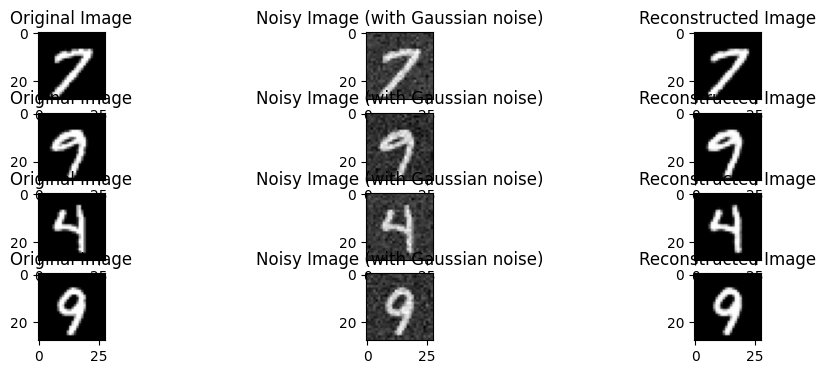

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

# Training the autoencoder with Gaussian noise
def train_autoencoder(model, dataloader, criterion, optimizer, device, noise_std=0.1, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for data in dataloader:
            inputs, _ = data
            inputs = inputs.to(device)

            # Add Gaussian noise to the inputs
            noise = torch.randn_like(inputs) * noise_std
            inputs_noisy = inputs + noise

            optimizer.zero_grad()

            outputs = model(inputs_noisy)
            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


# Visualize examples of input and reconstructed images with Gaussian noise
def visualize_with_noise(model, dataloader, noise_std=0.1, n=4):
    model.eval()
    fig, ax = plt.subplots(n, 3, figsize=(12, 4))

    for i in range(n):
        img, _ = next(iter(dataloader))
        img = img.to(device)

        # Add Gaussian noise to the inputs
        noise = torch.randn_like(img) * noise_std
        img_noisy = img + noise

        recon = model(img_noisy)

        img_ = img[0].detach().cpu().numpy().squeeze()
        img_noisy_ = img_noisy[0].detach().cpu().numpy().squeeze()
        recon_ = recon[0].detach().cpu().numpy().squeeze()

        ax[i, 0].imshow(img_, cmap='gray')
        ax[i, 0].set_title('Original Image')

        ax[i, 1].imshow(img_noisy_, cmap='gray')
        ax[i, 1].set_title('Noisy Image (with Gaussian noise)')

        ax[i, 2].imshow(recon_, cmap='gray')
        ax[i, 2].set_title('Reconstructed Image')

    plt.show()

# Usage
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the autoencoder with Gaussian noise
train_autoencoder(model, dataloader, criterion, optimizer, device, noise_std=0.1, num_epochs=10)

# Visualize examples with Gaussian noise
visualize_with_noise(model, dataloader, noise_std=0.1)

In [17]:
from google.colab import files

# Upload the Kaggle API key file (kaggle.json)
uploaded = files.upload()

# Move the uploaded file to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download CelebA dataset
!kaggle datasets download jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d /content/celeba
dataset_path = '/content/celeba/img_align_celeba'
batch_size=128

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open celeba-dataset.zip, celeba-dataset.zip.zip or celeba-dataset.zip.ZIP.


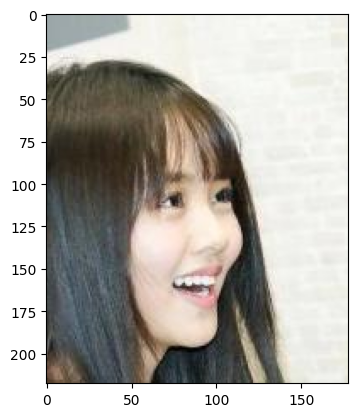

Epoch 1/10
6332/6332 [==============================] - 327s 51ms/step - loss: 0.4803
Epoch 2/10
6332/6332 [==============================] - 304s 48ms/step - loss: 0.4773
Epoch 3/10
 317/6332 [>.............................] - ETA: 5:15 - loss: 0.4765

KeyboardInterrupt: 

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load CelebA dataset
dataset_path = '/content/celeba/img_align_celeba/img_align_celeba'
image_filenames = os.listdir(dataset_path)
num_images = len(image_filenames)

# Display one sample image
sample_image_path = os.path.join(dataset_path, image_filenames[0])
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.show()

# Define custom dataset class
class CelebADataset(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, batch_size=32, input_size=(64, 64)):
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_filenames = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []

        for filename in batch_filenames:
            image_path = os.path.join(dataset_path, filename)
            image = Image.open(image_path).resize(self.input_size)
            image = np.array(image) / 255.0  # Normalize to [0, 1]
            batch_images.append(image)

        return np.array(batch_images), np.array(batch_images)

# Create an instance of the CelebA dataset class
batch_size = 32
celeba_dataset = CelebADataset(image_filenames, batch_size=batch_size)

# Build and compile the autoencoder
input_img = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(celeba_dataset, epochs=10, steps_per_epoch=len(celeba_dataset))

# Generate reconstructed images
sample_batch = celeba_dataset[0][0]
reconstructed_images = autoencoder.predict(sample_batch)

# Display original and reconstructed images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sample_batch[i])
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()